In [1]:
!pip install fingerprint_enhancer
import fingerprint_enhancer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.13-py3-none-any.whl size=8922 sha256=bbe1bae9bd123738a9e29961c895a5b57749be2f8d06e27ebc1283ee0a1029fa
  Stored in directory: /root/.cache/pip/wheels/91/ae/50/978165dd230375061475f4594febfe8a42869c4cc5374f9740
Successfully built fingerprint_enhancer


In [2]:
import numpy as np
import torch as T
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import glob
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import random
import numpy
import matplotlib.pyplot as plt
# from enhance import image_enhance
from skimage.morphology import skeletonize, thin
import torchvision.transforms as transforms
import torch

In [3]:
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#Replay Buffer

In [4]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

#Q_Network

In [5]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_size, output_size):
    super(DeepQNetwork, self).__init__()
    self.dense1 = nn.Linear(input_size, 128)
    self.dense2 = nn.Linear(128, 64)
    self.dense3 = nn.Linear(64, output_size)
    self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, x):
    x = F.relu(self.dense1(x))
    x = F.relu(self.dense2(x))
    x = self.dense3(x)
    return x

#Agent

In [6]:
class DDQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,replace=1000):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        # self.env_name = env_name
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr,self.input_dims,self.n_actions)
        self.q_next = DeepQNetwork(self.lr, self.input_dims,self.n_actions)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation,dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def replace_target_network(self):
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()

        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_)
        q_eval = self.q_eval.forward(states_)

        max_actions = T.argmax(q_eval, dim=1)
        q_next[dones] = 0.0

        q_target = rewards + self.gamma*q_next[indices, max_actions]
        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()

        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

    def save_models(self,path,n):
        torch.save({
            'model_state_dict': self.q_eval.state_dict()
        }, os.path.join(path,'dqn_q_eval_'+str(n)+'spd11.pth'))
        torch.save({
            'model_state_dict': self.q_next.state_dict()
        }, os.path.join(path,'dqn_q_next_'+str(n)+'spd11.pth'))
        # self.q_eval.save_checkpoint()
        # self.q_next.save_checkpoint()

    def load_models(self,file_path_eval,file_path_next):
        checkpoint = torch.load(file_path_eval, map_location=device)
        self.q_eval.load_state_dict(checkpoint['model_state_dict'])
        checkpoint = torch.load(file_path_next, map_location=device)
        self.q_next.load_state_dict(checkpoint['model_state_dict'])
        # self.q_eval.load_checkpoint()
        # self.q_next.load_checkpoint()

In [7]:
def get_descriptors(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    # img = image_enhance.image_enhance(img)
    # img = fingerprint_enhancer.enhance_Fingerprint(img)
    img = numpy.array(img, dtype=numpy.uint8)
    # Threshold
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Normalize to 0 and 1 range
    img[img == 255] = 1
    # skeleton = cv2.ximgproc.thinning(img, thinningType = cv2.ximgproc.THINNING_GUOHALL)
    #Thinning
    # skeleton = skeletonize(img)
    # skeleton = numpy.array(skeleton, dtype=numpy.uint8)
    # skeleton = self.removedot(skeleton)
    # Harris corners
    harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
    harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    threshold_harris = 125
    # Extract keypoints
    keypoints = []
    for x in range(0, harris_normalized.shape[0]):
      for y in range(0, harris_normalized.shape[1]):
        if harris_normalized[x][y] > threshold_harris:
          keypoints.append(cv2.KeyPoint(y, x, 1))
    # Define descriptor
    orb = cv2.ORB_create()
    # Compute descriptors
    _, des = orb.compute(img, keypoints)
    return (keypoints, des);
def isMatching(img1,img2):

    # img1 = cv2.imread("test_fprs/" + image_name1, cv2.IMREAD_GRAYSCALE)
    kp1, des1 = get_descriptors(img1)

    # img2 = cv2.imread("database/" + image_name2, cv2.IMREAD_GRAYSCALE)
    kp2, des2 = get_descriptors(img2)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key= lambda match:match.distance)

    score = 0
    for match in matches:
      score += match.distance

    score_threshold = 33
    return score/(len(matches)+1)

def isMatching_des(d1,d2):
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = sorted(bf.match(d1, d2), key= lambda match:match.distance)

  score = 0
  for match in matches:
    score += match.distance

  score_threshold = 33
  return score/(len(matches)+1)

# Utils

In [8]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [9]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [10]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 7 * 7, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

##Intersection over Union

In [11]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # print("IOU:",intersection / (box1_area + box2_area - intersection + 1e-6))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

##NMS Function

In [12]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [13]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

##Transforms

In [14]:
class testCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)

        return img

In [15]:
transform_test = testCompose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
model = model.to(DEVICE)

#Environment

In [18]:
def clean_data(base_path):
  for img in os.listdir(base_path):
    read = cv2.imread(base_path + img)
    outfile = img.split('.')[0] + '.jpg'
    cv2.imwrite(base_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 200])

In [98]:
!unzip "database.zip"

Archive:  database.zip
  inflating: database/101_1.tif      
  inflating: database/101_2.tif      
  inflating: database/101_3.tif      
  inflating: database/101_4.tif      
  inflating: database/101_5.tif      
  inflating: database/101_6.tif      
  inflating: database/101_7.tif      
  inflating: database/101_8.tif      
  inflating: database/102_1.tif      
  inflating: database/102_2.tif      
  inflating: database/102_3.tif      
  inflating: database/102_4.tif      
  inflating: database/102_5.tif      
  inflating: database/102_6.tif      
  inflating: database/102_7.tif      
  inflating: database/102_8.tif      
  inflating: database/103_1.tif      
  inflating: database/103_2.tif      
  inflating: database/103_3.tif      
  inflating: database/103_4.tif      
  inflating: database/103_5.tif      
  inflating: database/103_6.tif      
  inflating: database/103_7.tif      
  inflating: database/103_8.tif      
  inflating: database/104_1.tif      
  inflating: database/104_2

In [99]:
datapath = "database"

In [100]:
clean_data(datapath+"/")

In [101]:
def getdata_dataframe():
  persons = []
  image_paths = []
  images = Path(datapath).glob('*.tif') ## Change this when changing the dataset based on the extension of the images
  for image in images:
    img = str(image)
    person_id = img.split('/')[-1].split('.')[0]
    persons.append(person_id)
    image_paths.append(img)
  return persons,image_paths

In [102]:
data = pd.DataFrame()
persons,image_paths = getdata_dataframe()
data['id'] = persons
data['path'] = image_paths

In [103]:
data.head()

id                path
0  101_7  database/101_7.tif
1  103_2  database/103_2.tif
2  110_1  database/110_1.tif
3  107_5  database/107_5.tif
4  108_2  database/108_2.tif

In [104]:
image = str(data.iloc[0]['path'])
image = image2 = cv2.imread(image,0)

In [105]:
descs = []
for ind in data.index:
  im = cv2.imread(data.iloc[ind]['path'],0)
  k, d = get_descriptors(im)
  descs.append(d)

## Environment

In [96]:
class Environment:
  # list[x,y,width1,width2,height1,height2]
  def __init__(self,image,state,data,id,pixel_size):
    self.w1 = state[2]#width1
    self.w2 = state[3] #width2
    self.h1 = state[4] # height1
    self.h2 = state[5] #height2
    self.pixel = pixel_size
    self.image=image
    self.data = data
    self.id =id
    self.x = state[0] #x
    self.y = state[1]
    self.total_rows = self.image.shape[0]
    self.total_columns = self.image.shape[1]
    self.action_count = 10

  def step(self,action):
     # list[x,y,width1,width2,height1,height2]
    flag = self.act(action)
    reward = 0  
    if  flag:
      value,done = self.get_reward()
      reward = value
    else:
      reward = 0
      if  self.action_count:
        done = 0
        self.action_count -= 1 
      else:
        done = 1

    next_state = [self.x,self.y,self.w1,self.w2,self.h1,self.h2]
    return next_state,reward,done

  def act(self,action):
    flag = 1
    if action == 0:
      #Increase width1
      change = self.w1 + self.pixel
      if self.y-change <= 0 :
        flag = 0
      else:
        self.w1 = self.w1 + self.pixel
    
    if action == 1:
      #Decrease width1
      change = self.w1-self.pixel
      if self.y-change >= self.y:
        flag = 0
      else:
        self.w1 = self.w1 - self.pixel
    
    if action == 2:
      #increase width2
      change = self.w2 + self.pixel
      if self.y+change >= self.total_columns:
        flag = 0
      else:
        self.w2 = self.w2 + self.pixel

    if action == 3:
      #Decrease width2
      change = self.w2 - self.pixel
      if self.y +change <= self.y:
        flag = 0
      else:
        self.w2 = self.w2 - self.pixel

    if action == 4:
      #increase height1
      change = self.h1 + self.pixel
      if self.x-change <= 0:
        flag = 0
      else:
        self.h1 = self.h1 + self.pixel

    if action == 5:
      #Decrease height1
      change = self.h1 - self.pixel
      if self.x-change >=self.x:
        flag = 0
      else:
          self.h1 = self.h1 - self.pixel

    if action == 6:
      #increase height2
      change = self.h2 + self.pixel
      if self.x+change >= self.total_rows:
        flag = 0
      else:
        self.h2 = self.h2 + self.pixel

    if action == 7:
      #Decrease height2
      change = self.h2 - self.pixel
      if self.x+change <= self.x:
        flag = 0
      else:
        self.h2 = self.h2 - self.pixel
    # print("Returning flag",flag)
    return flag


  def compare_all(self,image):
    scores = []
    k, d = get_descriptors(image)
    for i in descs:
      scores.append(isMatching_des(d,i))
    if scores.count(0) == len(scores):
      print("all zeroes")
      borderPassed=0
      return -1,0
    else:
      value = min(scores)
      print(scores)
      max_index = scores.index(value)
      value = 100-value
      print(self.data.iloc[max_index]['id'], value)
      return value,max_index

  def get_reward(self):
    crop_image = self.image[self.x-self.h1:self.x+self.h2,self.y-self.w1:self.y+self.w2]
    value,max_index = self.compare_all(crop_image)
    if value != -1:
      if self.data.iloc[max_index]['id'][0:3] == self.id[0:3]: ## Change this when changing the dataset based on how the impressions are labelled
        return value,1
      elif self.data.iloc[max_index]['id'][0:3] != self.id[0:3]: ## Change this when changing the dataset based on how the impressions are labelled
        return -1*(value-30),0
    else:
      return -50,0


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
## Loading the yolo model for yolo bbox predictions
## Change the model based on the database we are currently working on

state_dict = torch.load('/content/drive/MyDrive/spd_500_200.pth',map_location=device)
print(state_dict.keys())
model.load_state_dict(state_dict)

odict_keys(['darknet.0.conv.weight', 'darknet.0.batchnorm.weight', 'darknet.0.batchnorm.bias', 'darknet.0.batchnorm.running_mean', 'darknet.0.batchnorm.running_var', 'darknet.0.batchnorm.num_batches_tracked', 'darknet.2.conv.weight', 'darknet.2.batchnorm.weight', 'darknet.2.batchnorm.bias', 'darknet.2.batchnorm.running_mean', 'darknet.2.batchnorm.running_var', 'darknet.2.batchnorm.num_batches_tracked', 'darknet.4.conv.weight', 'darknet.4.batchnorm.weight', 'darknet.4.batchnorm.bias', 'darknet.4.batchnorm.running_mean', 'darknet.4.batchnorm.running_var', 'darknet.4.batchnorm.num_batches_tracked', 'darknet.5.conv.weight', 'darknet.5.batchnorm.weight', 'darknet.5.batchnorm.bias', 'darknet.5.batchnorm.running_mean', 'darknet.5.batchnorm.running_var', 'darknet.5.batchnorm.num_batches_tracked', 'darknet.6.conv.weight', 'darknet.6.batchnorm.weight', 'darknet.6.batchnorm.bias', 'darknet.6.batchnorm.running_mean', 'darknet.6.batchnorm.running_var', 'darknet.6.batchnorm.num_batches_tracked', 'da

<All keys matched successfully>

In [32]:
from PIL import Image
import PIL

In [33]:
## returns final bboxes after passing an image to pretrained yolo model
def get_img_result(img_path):
  img_path = img_path.split(".")[0]+".jpg"
  test_image = Image.open(img_path)
  test_image_tensor = transform_test(test_image)
  
  output = model(test_image_tensor.unsqueeze(0).to(DEVICE))
  output = output.reshape(-1,7,7,30)
  boxes = cellboxes_to_boxes(output, S=7)
  boxes = torch.tensor(boxes).squeeze(0)
  boxes = boxes.tolist()
  nms_boxes = non_max_suppression(boxes, 0.5, 0.4)
  return nms_boxes


In [65]:
## randomly selects a fingerprint image from database, extracts yolo bbox using loaded yolo model
## returns the state of the environment as (x,y,w1,w2,h1,h2) for that image
def set_env():
  index = random.randint(0,data.shape[0]-1)
  id = data.iloc[index]['id']
  print("------------------ ",id," -------------------")
  image = cv2.imread(str(data.iloc[index]['path']),0)
  nms_boxes = get_img_result(str(data.iloc[index]['path']))
  if len(nms_boxes)==0:
    x = image.shape[0]//2
    y = image.shape[1]//2
    width1 = y//4
    width2= y//4
    height1= x//4
    height2= x//4
    state = [x,y,width1,width2,height1,height2]
    return image,state,id
  width = image.shape[1]
  height = image.shape[0]
  bbox = nms_boxes[0][2:]
  print(bbox)
  state = [bbox[1]*height, bbox[0]*width, (bbox[2]*width)/2, (bbox[2]*width)/2, (bbox[3]*height)/2,(bbox[3]*height)/2]
  state = [int(i) for i in state]
  # state = [x,y,width1,width2,height1,height2]
  return image,state,id

In [35]:
batch_size = 64         # minibatch size
gamma = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters     
state_size = 6
action_size= 8
epsilon=1.0
eps_min=0.01
replace=50
eps_dec=1e-4
mem_size = 1000000

In [37]:
agent = DDQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,
                  input_dims=state_size,
                  n_actions=action_size, mem_size=50000, eps_min=0.1,
                  batch_size=64, replace=100, eps_dec=5e-5)

<ipython-input-4-b0ccf1341747>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


In [ ]:
num_epochs = 1000
scores=[]
eps_history=[]
avg_scores=[]
count = 150

for i in range(num_epochs):
  done = False
  score = 0

  image,state,id = set_env()
  env = Environment(image,state,data,id,5)

  while not done:
    count = count-1
    action = agent.choose_action(torch.tensor(state,dtype=torch.float))
    # print(type(action),action)
    next_state,reward,done = env.step(action)
    score += reward

    agent.store_transition(torch.tensor(state),action,reward,torch.tensor(next_state),int(done))
    agent.learn()
    state = next_state

    if count == 0:
      break
  scores.append(score)
  avg_score = np.mean(scores[-50:])
  avg_scores.append(avg_score)
  
  print('episode: ', i,'score: ', score,
             ' average score %.1f' % avg_score,'epsilon %.2f' % agent.epsilon)
  eps_history.append(agent.epsilon)

------------------  108_4  -------------------


KeyboardInterrupt: ignored

In [ ]:
f = open("avg_scores.txt","r")
avg_scores=[float(i.strip()) for i in f.readlines()]

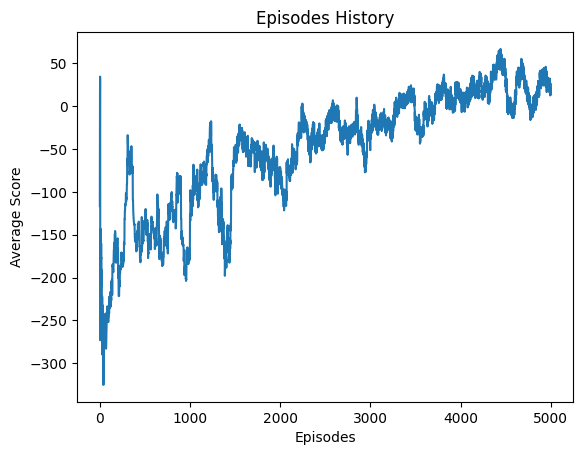

In [ ]:
import matplotlib.pyplot as plt
  
# line 1 points
# x1 = range(len(eps_history))
# y1 = eps_history
# plotting the line 1 points 
# plt.plot(x1, y1, label = "Epsilon")
  
# # line 2 points
x2 = range(len(avg_scores[0:]))
y2 = avg_scores[0:]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Average Score")

# plt.ylim(-800, 200)
# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Average Score')
# giving a title to my graph
plt.title('Episodes History')
  
# show a legend on the plot
# plt.legend()
  
# function to show the plot
plt.show()

### Saving the model

In [ ]:
agent.save_models("/content/drive/MyDrive",len(data.index))

### Loading the model

In [77]:
agent.load_models("/content/drive/MyDrive/dqn_q_eval_100spd11.pth","/content/drive/MyDrive/dqn_q_next_100spd11.pth")
## Change the model based on the database we are currently working on

Testing 

Goal of the function is to modify the boundig box so pass yolos bounding box as a state and using agent ,at each state find the action which give maaximum value and perform that action on the image ,repeat this until reward is 1.

In [78]:
## shows cropped image based on state
def show_crop_image(image,state):
  # print(state[0]-state[2],state[0]+state[3],state[1]-state[4],state[1]-state[5])
  crop_image = image[state[0]-state[4]:state[0]+state[5],state[1]-state[2]:state[1]+state[3]]
  gray = cv2.cvtColor(crop_image, cv2.COLOR_GRAY2RGB)
  plt.imshow(gray)
  plt.axis('off')
  plt.show()

In [79]:
import matplotlib.patches as patches
## prints bbox on fingerprint image when state is given
def show_img_bbox(image,state):
    f, axarr = plt.subplots()
    cv2_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(cv2_img)
    # image = Image.open("database/"+id+".jpg")
    width, height = image.size
    # image = transform_test(image)
    # im = np.array(image)
    # im = np.transpose(im, (1, 2, 0))
    # height, width, _ = im.shape
    axarr.imshow(image)
    upper_left_x = state[0]-state[4]
    upper_left_y = state[1]-state[2]
    rect = patches.Rectangle(
        (upper_left_y, upper_left_x),
        state[2]+state[3],
        state[4]+state[5],
        linewidth=2,
        edgecolor="b",
        facecolor="none",
    )
    # Add the patch to the Axes
    axarr.add_patch(rect)
    axarr.axis('off')
    plt.show()

In [80]:
## YOLO, DDQN bboxes in one image
def show_bbox_yolo_ddqn(image,yolo_state,ddqn_state):
    f, axarr = plt.subplots()
    cv2_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(cv2_img)
    width, height = image.size
    # image = transform_test(image)
    # im = np.array(image)
    # im = np.transpose(im, (1, 2, 0))
    # height, width, _ = im.shape
    axarr.imshow(image)
    state = yolo_state
    upper_left_x = state[0]-state[4]
    upper_left_y = state[1]-state[2]
    rect = patches.Rectangle(
        (upper_left_y, upper_left_x),
        state[2]+state[3],
        state[4]+state[5],
        linewidth=2,
        edgecolor="b",
        facecolor="none",
    )
    # Add the patch to the Axes
    axarr.add_patch(rect)
    state = ddqn_state
    upper_left_x = state[0]-state[4]
    upper_left_y = state[1]-state[2]
    rect = patches.Rectangle(
        (upper_left_y, upper_left_x),
        state[2]+state[3],
        state[4]+state[5],
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
    # Add the patch to the Axes
    axarr.add_patch(rect)
    axarr.axis('off')
    # plt.savefig("imp_10_10/"+str(id)+"_ddqn.png")
    plt.show()

In [83]:
## Tests and prints yolo, ddqn, cropped image results on a random fingerprint from the database
def Test(image,state,id,agent): # pass image ,state,id from yolo(if DDQN train on yolo)
  count = 200 # For safety, actually we should not use this while testing but let'see

  env = Environment(image,state,data,id,10) # Based on the passed information initialize the env
  print(state)
  cv2_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img1 = Image.fromarray(cv2_img)
  width, height = img1.size
  plt.imshow(img1)
  plt.axis('off')
  plt.show()

  yolo_state = list(state)
  
  show_img_bbox(image,state)

  state[2]+=(0.1)*image.shape[1]+10
  state[3]+=(0.1)*image.shape[1]+10
  state[4]+=(0.1)*image.shape[0]+10
  state[5]+=(0.1)*image.shape[0]+10
  state = [int(i) for i in state]

  score = 0
  scores = []
  states = []
  while True: # Perform actions until it recognise the image(using reward as flag because if it recofnise ,will give reward as 1)
    action = agent.choose_action(torch.tensor(state,dtype=torch.float))
    next_state,reward,done = env.step(action) # get reward
    score += reward
    scores.append(reward)
    states.append(state)
    state = next_state
    print(next_state,reward,done)
    # show_crop_image(image,state)
    # show_img_bbox(image,state)
    if done==True:
      break
    count = count-1
    if count == 0:
      break
  show_bbox_yolo_ddqn(image,yolo_state,state)
  show_crop_image(image,state)
  avg_score = np.mean(scores)
  # print("Avg Score",avg_score)
  return state

In [108]:
## Prints all resuts when img path and its id are given
## original image, yolo bbox, yolo-ddqn bbox, 
def print_img_results(img_path,test_id):
  print("########### "+str(test_id)+" #############")
  image = cv2.imread(img_path,0)

  cv2_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img1 = Image.fromarray(cv2_img)

  plt.imshow(img1)
  plt.axis('off')
  plt.show()
  nms_boxes = get_img_result(img_path)
  
  width = image.shape[1]
  height = image.shape[0]
  if len(nms_boxes)==0:
    x = image.shape[0]//2
    y = image.shape[1]//2
    width1 = y//4
    width2= y//4
    height1= x//4
    height2= x//4
    state = [x,y,width1,width2,height1,height2]
  else:
    bbox = nms_boxes[0][2:]
    state = [bbox[1]*height, bbox[0]*width, (bbox[2]*width)/2, (bbox[2]*width)/2, (bbox[3]*height)/2,(bbox[3]*height)/2]
    state = [int(i) for i in state]
  
  print(state)
  yolo_state = list(state)
  show_img_bbox(image,state)

  ## Expanding the bbox
  state[2]+=(0.1)*image.shape[1]+10
  state[3]+=(0.1)*image.shape[1]+10
  state[4]+=(0.1)*image.shape[0]+10
  state[5]+=(0.1)*image.shape[0]+10
  state = [int(i) for i in state]

  ## Checking if the bbox crosses img boundaries
  if state[0]-state[4]<=0:
    state[4]=state[0]-5
  if state[0]+state[5]>=height:
    state[5]=height-5-state[0]
  if state[1]-state[2]<=0:
    state[2]=state[1]-5
  if state[1]+state[3]>=width:
    state[3]=width-5-state[1]
  

  env = Environment(image,state,data,test_id,10)
  count=150
  while True: 
    action = agent.choose_action(torch.tensor(state,dtype=torch.float))
    next_state,reward,done = env.step(action) # get reward
    state = next_state
    # print("--------Reward----------   ",reward)
    if reward>=80 and done==True:
      break
    count = count-1
    if count == 0:
      break
  
  crop_image = image[state[0]-state[4]:state[0]+state[5],state[1]-state[2]:state[1]+state[3]]
  show_bbox_yolo_ddqn(image,yolo_state,state)

1 . Try Testing with YOLO Output

2. Take the returned state from the Test function and Draw the bounding box like Yolo's Output.

3.If it is working fine add the result to report.

------------------  108_3  -------------------
[0.4592883586883545, 0.7592357993125916, 0.274666965007782, 0.257190465927124]
[425, 135, 40, 40, 72, 72]


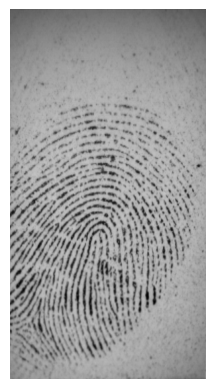

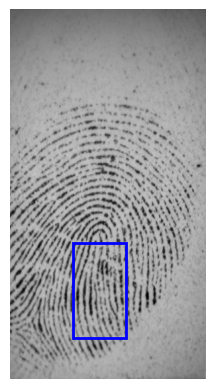

[13.714285714285714, 19.4, 21.0, 16.333333333333332, 17.09090909090909, 23.5, 18.166666666666668, 14.75, 22.375, 9.0, 14.25, 17.0, 17.46153846153846, 18.22222222222222, 17.857142857142858, 19.193548387096776, 13.7, 15.666666666666666, 17.5, 12.571428571428571, 20.4, 15.857142857142858, 12.0, 13.666666666666666, 17.833333333333332, 9.0, 5.666666666666667, 20.428571428571427, 37.875, 22.875, 15.666666666666666, 16.666666666666668, 19.142857142857142, 35.625, 17.8, 10.0, 13.833333333333334, 12.0, 19.5, 18.444444444444443, 19.0, 27.375, 14.8, 20.0, 21.857142857142858, 18.333333333333332, 19.5, 21.22222222222222, 18.6, 10.75, 8.166666666666666, 34.27272727272727, 16.133333333333333, 16.0, 18.833333333333332, 20.1, 16.8, 14.0, 29.272727272727273, 19.5, 18.88888888888889, 8.0, 17.333333333333332, 22.2, 23.0, 16.8, 3.0, 40.166666666666664, 14.9, 11.0, 23.5, 18.2, 14.6, 10.833333333333334, 4.666666666666667, 14.875, 7.0, 18.75, 20.5, 20.545454545454547]
101_2 97.0
[425, 135, 40, 50, 72, 72] -67

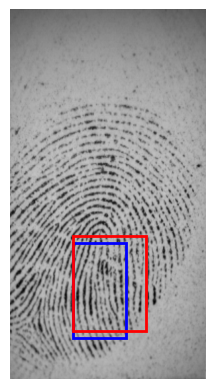

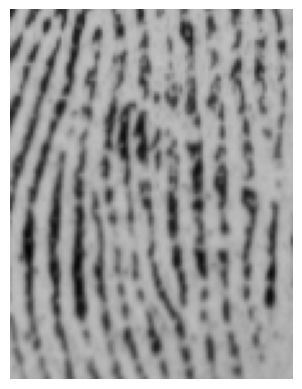

[425, 135, 40, 70, 82, 62]

In [106]:
image,state,id = set_env()
Test(image,state,id,agent)

## Image Results

########### 101_1 #############


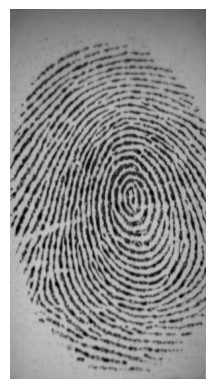

[271, 182, 42, 42, 73, 73]


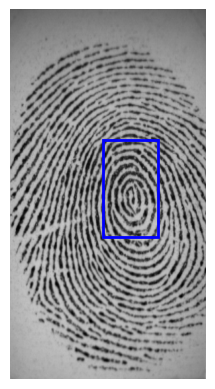

[39.44094488188976, 47.24778761061947, 49.92307692307692, 48.54838709677419, 45.4344262295082, 47.31325301204819, 49.5, 48.35344827586207, 44.696969696969695, 44.666666666666664, 47.40594059405941, 45.67175572519084, 44.77142857142857, 46.06837606837607, 47.69662921348315, 44.40217391304348, 46.79047619047619, 49.10144927536232, 46.355555555555554, 46.794392523364486, 47.291666666666664, 48.0, 45.864583333333336, 47.964285714285715, 46.6865671641791, 46.411764705882355, 49.93023255813954, 48.96052631578947, 49.20634920634921, 46.834782608695654, 48.94202898550725, 45.357142857142854, 47.23893805309734, 50.767857142857146, 45.7787610619469, 49.525, 46.137614678899084, 45.23931623931624, 47.82828282828283, 47.11818181818182, 45.64356435643565, 51.80722891566265, 47.85294117647059, 53.3125, 49.489583333333336, 50.3968253968254, 50.48888888888889, 49.38202247191011, 39.321100917431195, 47.857142857142854, 47.70454545454545, 47.07874015748032, 45.48760330578512, 45.76923076923077, 50.718181

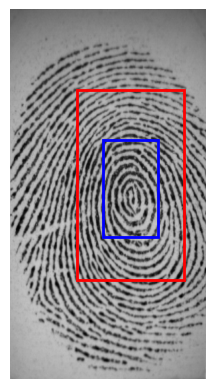

In [107]:
test_image = "101_1.tif"
print_img_results ("database/"+test_image,test_image.split(".")[0])

########### 101_7 #############


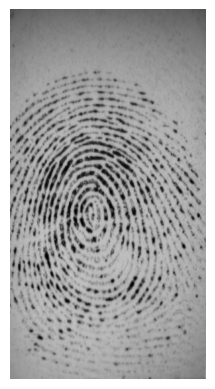

[293, 111, 42, 42, 71, 71]


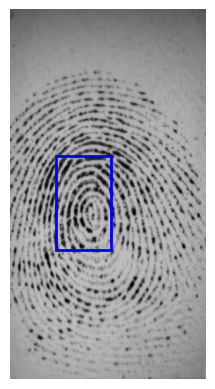

[7.0854430379746836, 39.2, 40.829268292682926, 37.14666666666667, 32.48979591836735, 41.08888888888889, 40.43589743589744, 38.26923076923077, 32.107142857142854, 26.95744680851064, 32.392857142857146, 37.104166666666664, 35.067796610169495, 34.98571428571429, 39.142857142857146, 25.339622641509433, 36.707317073170735, 45.0, 42.44897959183673, 35.58461538461538, 33.333333333333336, 38.526315789473685, 31.793650793650794, 44.029411764705884, 39.01754385964912, 40.857142857142854, 44.32, 43.779661016949156, 45.958333333333336, 41.189189189189186, 41.65853658536585, 36.875, 33.170212765957444, 46.204819277108435, 35.58620689655172, 43.26190476190476, 38.41379310344828, 45.059701492537314, 37.833333333333336, 43.582089552238806, 35.847457627118644, 46.06666666666667, 35.91803278688525, 46.41935483870968, 40.705882352941174, 38.83018867924528, 43.022222222222226, 40.568627450980394, 39.78181818181818, 41.86363636363637, 42.28846153846154, 45.61607142857143, 33.38461538461539, 33.628571428571

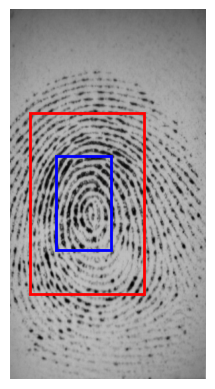

########### 101_3 #############


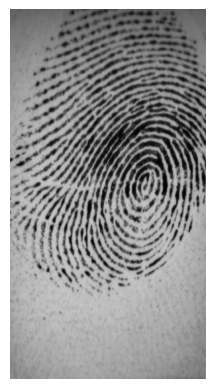

[280, 148, 37, 37, 70, 70]


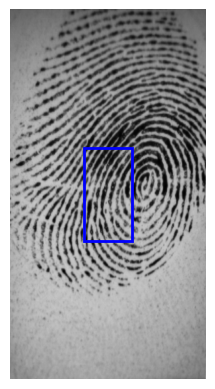

[38.567567567567565, 43.07936507936508, 45.29090909090909, 41.26984126984127, 39.82142857142857, 42.32835820895522, 44.355555555555554, 42.94642857142857, 38.791044776119406, 37.57142857142857, 40.035714285714285, 38.94897959183673, 40.101694915254235, 40.52777777777778, 41.14035087719298, 39.10666666666667, 40.3968253968254, 43.36666666666667, 43.42857142857143, 7.265536723163842, 41.95522388059702, 43.71666666666667, 40.82716049382716, 44.93023255813954, 42.57142857142857, 41.723076923076924, 42.65, 42.55384615384615, 46.57843137254902, 43.6025641025641, 43.80555555555556, 42.56060606060606, 41.95238095238095, 45.92857142857143, 41.46511627906977, 48.31818181818182, 40.838235294117645, 47.11864406779661, 43.30909090909091, 43.375, 40.55128205128205, 46.45161290322581, 40.869565217391305, 46.208333333333336, 44.529411764705884, 45.421052631578945, 42.95, 47.02985074626866, 45.333333333333336, 41.42553191489362, 41.074074074074076, 46.43010752688172, 38.56521739130435, 40.1463414634146

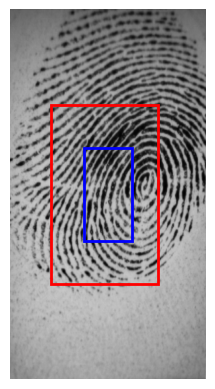

########### 101_5 #############


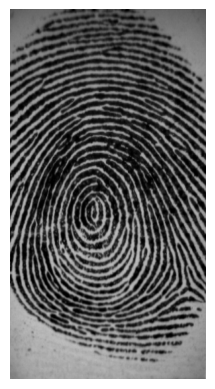

[295, 143, 41, 41, 70, 70]


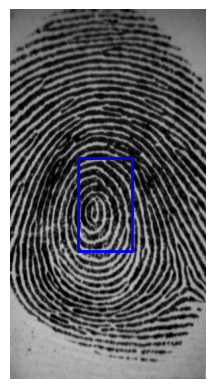

[46.88095238095238, 49.104166666666664, 46.31666666666667, 48.490566037735846, 44.87234042553192, 48.869565217391305, 50.372093023255815, 48.80487804878049, 48.26086956521739, 46.46875, 44.76923076923077, 46.851063829787236, 45.69444444444444, 49.78125, 49.34090909090909, 48.407407407407405, 48.774193548387096, 49.78947368421053, 45.36206896551724, 44.333333333333336, 50.9375, 45.338235294117645, 46.666666666666664, 51.291666666666664, 42.09375, 46.51162790697674, 38.34, 48.58536585365854, 50.58620689655172, 44.725806451612904, 44.93617021276596, 48.75, 47.92307692307692, 46.610169491525426, 46.28947368421053, 44.8125, 45.0, 8.65296803652968, 49.39393939393939, 48.73076923076923, 48.285714285714285, 48.388888888888886, 47.027027027027025, 46.21621621621622, 50.648148148148145, 49.54, 47.0625, 47.0, 42.01449275362319, 42.3, 47.205128205128204, 30.56198347107438, 45.32432432432432, 49.7906976744186, 49.041666666666664, 49.67857142857143, 48.17307692307692, 46.67796610169491, 48.666666666

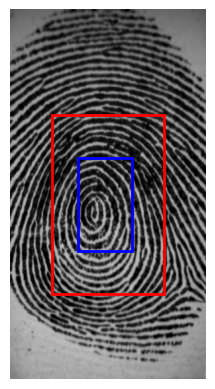

########### 101_4 #############


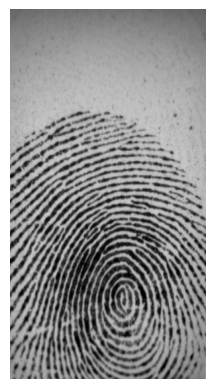

[429, 144, 40, 40, 64, 64]


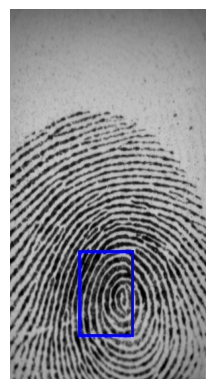

[45.45263157894737, 51.205882352941174, 51.08108108108108, 50.53333333333333, 48.8125, 49.73015873015873, 52.371428571428574, 51.848101265822784, 48.0, 45.370370370370374, 47.609756097560975, 49.320388349514566, 47.88, 47.705882352941174, 49.516666666666666, 45.46031746031746, 49.766666666666666, 52.43181818181818, 48.45762711864407, 49.876543209876544, 49.1875, 48.486486486486484, 47.74285714285714, 51.170212765957444, 46.53061224489796, 50.31818181818182, 49.4, 49.92857142857143, 51.27472527472528, 48.013888888888886, 48.35, 49.791666666666664, 50.28125, 52.72527472527472, 49.10666666666667, 49.66197183098591, 48.79012345679013, 39.12765957446808, 51.559322033898304, 49.51190476190476, 48.53968253968254, 53.63934426229508, 49.559322033898304, 51.5945945945946, 50.01470588235294, 49.76623376623377, 50.971014492753625, 51.49230769230769, 13.641666666666667, 50.327586206896555, 50.41379310344828, 43.4954128440367, 48.10112359550562, 48.83116883116883, 51.246753246753244, 51.423076923076

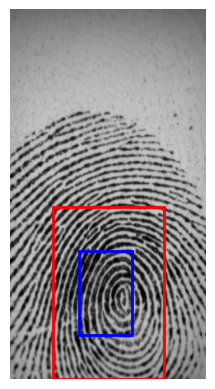

########### 101_6 #############


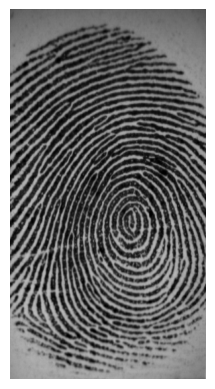

[353, 182, 39, 39, 73, 73]


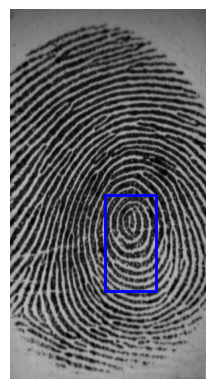

[48.435483870967744, 50.12903225806452, 51.73015873015873, 51.791666666666664, 49.86363636363637, 50.1875, 52.40677966101695, 50.36923076923077, 49.592592592592595, 49.51162790697674, 48.093333333333334, 50.602739726027394, 50.42, 51.67741935483871, 50.67307692307692, 49.395833333333336, 50.06896551724138, 50.578947368421055, 47.09230769230769, 49.25, 52.25423728813559, 48.30508474576271, 51.59375, 52.36585365853659, 49.395348837209305, 49.75409836065574, 47.206896551724135, 48.95744680851064, 51.18571428571428, 48.5, 50.69491525423729, 49.904761904761905, 51.05263157894737, 52.098765432098766, 52.36486486486486, 47.583333333333336, 49.0655737704918, 35.963855421686745, 51.4, 52.34177215189873, 51.98245614035088, 50.16326530612245, 49.5, 49.526315789473685, 49.16981132075472, 52.46913580246913, 52.2, 48.888888888888886, 46.666666666666664, 49.86538461538461, 49.98076923076923, 7.431818181818182, 50.38095238095238, 48.81395348837209, 52.73913043478261, 53.333333333333336, 49.21875, 48.3

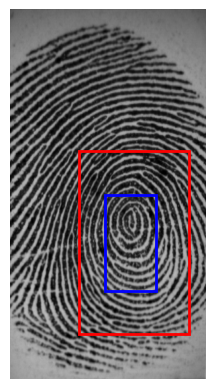

########### 101_2 #############


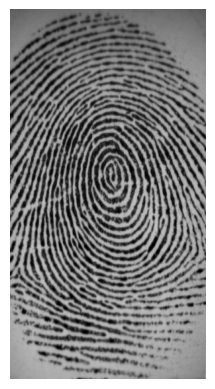

[257, 149, 41, 41, 72, 72]


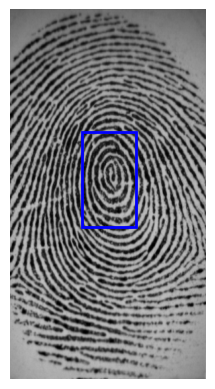

[49.56880733944954, 52.0, 52.39449541284404, 53.09345794392523, 51.10909090909091, 48.46341463414634, 52.96666666666667, 52.241379310344826, 51.50515463917526, 49.65384615384615, 49.34653465346535, 50.3801652892562, 52.629629629629626, 50.627272727272725, 50.525252525252526, 51.81818181818182, 50.51948051948052, 51.172413793103445, 49.451219512195124, 50.55670103092783, 52.15, 50.2, 50.54945054945055, 52.62903225806452, 51.916666666666664, 49.73529411764706, 47.42045454545455, 50.6025641025641, 50.27619047619048, 47.2952380952381, 49.36363636363637, 50.48421052631579, 51.40816326530612, 50.59, 50.716981132075475, 49.023809523809526, 49.252631578947366, 43.75423728813559, 53.93827160493827, 51.92, 52.39, 53.48101265822785, 52.57608695652174, 54.916666666666664, 51.175824175824175, 52.109375, 51.53947368421053, 49.94736842105263, 40.9, 47.620253164556964, 52.44318181818182, 41.57142857142857, 51.1651376146789, 49.80232558139535, 52.48623853211009, 54.372093023255815, 51.91891891891892, 5

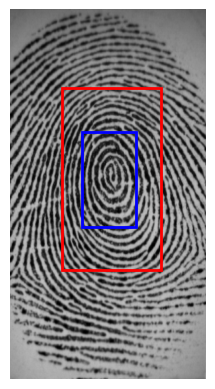

########### 101_1 #############


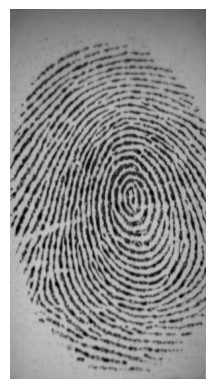

[271, 182, 42, 42, 73, 73]


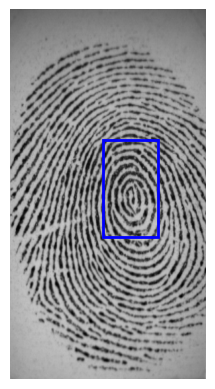

[41.99090909090909, 48.38317757009346, 51.023529411764706, 49.385416666666664, 46.99152542372882, 49.25, 52.08641975308642, 49.604395604395606, 46.83838383838384, 46.79365079365079, 47.39795918367347, 47.760330578512395, 48.61290322580645, 47.89622641509434, 49.19178082191781, 46.24390243902439, 48.61538461538461, 50.515151515151516, 48.36842105263158, 47.02173913043478, 49.320754716981135, 50.15, 47.544444444444444, 49.98148148148148, 49.53125, 47.67777777777778, 50.394366197183096, 51.21686746987952, 50.45454545454545, 48.24770642201835, 49.015625, 46.55670103092783, 49.53333333333333, 51.42307692307692, 47.166666666666664, 49.95180722891566, 48.34375, 45.344086021505376, 49.0, 48.627450980392155, 46.78048780487805, 52.50666666666667, 49.31325301204819, 54.73913043478261, 48.69662921348315, 51.252747252747255, 50.851351351351354, 49.66216216216216, 39.6530612244898, 49.28947368421053, 48.39506172839506, 46.85964912280702, 47.05882352941177, 47.792682926829265, 51.98076923076923, 51.6

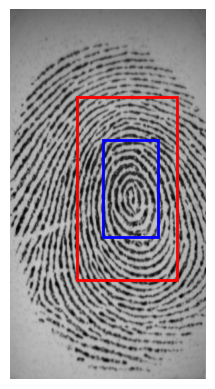

########### 101_8 #############


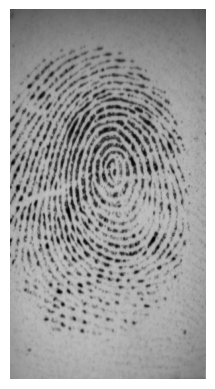

[251, 152, 43, 43, 72, 72]


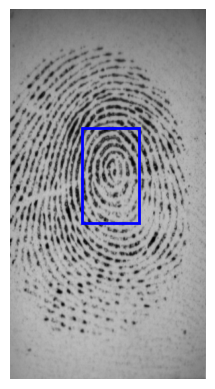

[23.90740740740741, 40.63492063492063, 40.775, 38.0, 35.25352112676056, 41.59649122807018, 40.921052631578945, 36.5, 30.88157894736842, 27.942857142857143, 34.964285714285715, 32.86516853932584, 32.745098039215684, 34.3134328358209, 39.05172413793103, 31.551724137931036, 36.0, 46.21052631578947, 41.22727272727273, 37.61194029850746, 35.82142857142857, 41.285714285714285, 35.01851851851852, 43.78947368421053, 37.853658536585364, 43.0625, 43.214285714285715, 44.95454545454545, 46.85840707964602, 42.76543209876543, 41.25806451612903, 38.84615384615385, 37.638297872340424, 45.91304347826087, 39.027027027027025, 42.34090909090909, 37.986301369863014, 44.12987012987013, 40.224137931034484, 40.679245283018865, 34.803030303030305, 44.03448275862069, 37.53703703703704, 49.31818181818182, 43.42857142857143, 40.660377358490564, 41.48979591836735, 40.905660377358494, 40.44827586206897, 41.1, 40.21568627450981, 44.826530612244895, 32.76829268292683, 33.372549019607845, 40.111111111111114, 37.793103

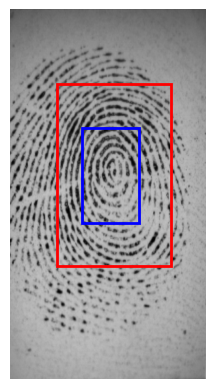

In [109]:
## iterate through all the images in database and print results for all
for i in os.listdir("database"):
  if i.split(".")[1]=="tif" and i.split(".")[0][0:3]=='101': ## selective images only
    print_img_results("database/"+i,i.split(".")[0])

########### 102_2 #############


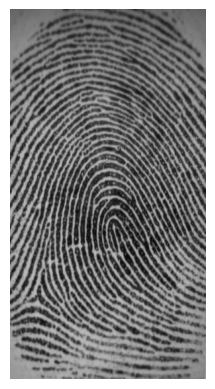

[336, 154, 43, 43, 75, 75]


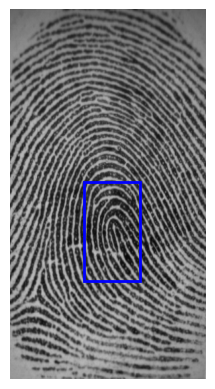

[50.37313432835821, 48.03488372093023, 51.71084337349398, 52.03529411764706, 49.42465753424658, 46.273809523809526, 54.0375, 50.86407766990291, 52.666666666666664, 46.833333333333336, 48.445945945945944, 48.72115384615385, 49.96491228070175, 49.48888888888889, 48.473684210526315, 51.57627118644068, 52.927536231884055, 50.297872340425535, 48.225352112676056, 52.33783783783784, 53.0253164556962, 46.92424242424242, 51.45783132530121, 49.63636363636363, 52.404761904761905, 38.26262626262626, 43.16216216216216, 48.8780487804878, 38.424778761061944, 46.23913043478261, 47.1875, 50.80232558139535, 52.23529411764706, 42.40384615384615, 50.2906976744186, 45.75, 45.795698924731184, 49.976470588235294, 50.5, 50.56382978723404, 49.64102564102564, 48.925925925925924, 53.66233766233766, 54.170212765957444, 47.89873417721519, 52.21212121212121, 45.911764705882355, 48.136986301369866, 53.7536231884058, 48.15151515151515, 49.42028985507246, 48.87096774193548, 51.104651162790695, 49.725806451612904, 49.8

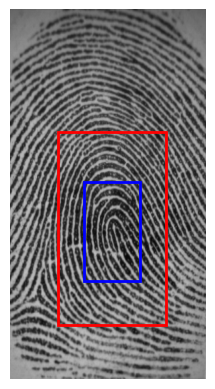

In [113]:
test_img = random.choice([i for i in os.listdir("database") if i.split(".")[1]=="tif"])
print_img_results("database/"+test_img,test_img.split(".")[0])